# Example code for LaseNet - recover one continuous latent variable

This is the colab example for LaseNet. The code only shows recovering one continuous latent variable. For more details, please refer to the README.md file.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!rm -rf lasenet # clear up dir if any
!git clone https://github.com/ti55987/lasenet

Cloning into 'lasenet'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 96 (delta 35), reused 82 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 467.90 KiB | 3.12 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [3]:
%cd lasenet
%ls

/content/lasenet
benchmarks/      eval.ipynb  mice_fitting/   README.md    training/       utils/
environment.yml  LICENSE     pretrained.sh*  simulation/  training.ipynb


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from utils.feature_utils import (
    get_onehot_features,
    get_feature_list_by_model,
    get_latent_labels,
    CognitiveModel,
)
from utils.training_utils import set_seed

from training.models import create_model

# Customize for your own path, latent variable name, and features

In [ ]:
DRIVE_DIR = 'CHANGE_ME' # your own google drive path
RESULT_DIR = 'CHANGE_ME' # your google drive path to store results
# parameter list you want to recover
target_parameter_name = '' # Change to your parameter name

# CHANGE TO YOUR OWN FEATURES
feature_list = []#  e.g. 'actions', 'rewards', 'stimuli'
training_data_file_path = f'{DRIVE_DIR}/CHANGE_ME.csv'
test_data_file_path = f'{DRIVE_DIR}/CHANGE_ME.csv'

# Process data

## Example data - skip this if you understand the data structure

In [5]:
import tqdm
import random

from simulation.prl.simulate_4prl import simulate_4prl

model_name = CognitiveModel.PRL4
num_agents = 10
num_trials = 500

data_list = []
for a in tqdm.tqdm(range(num_agents)):
    rand_beta = random.uniform(1e-4, 10)
    rand_alpha = random.uniform(1e-4, 1)
    rand_neg_alpha = random.uniform(1e-4, 1)
    rand_stickiness = random.uniform(0, 1)

    parameters = [rand_beta, rand_alpha, rand_neg_alpha, rand_stickiness]
    example = simulate_4prl(parameters, num_trials, 0.8, 15, 2, a)
    data_list.append(example)

example_df = pd.concat(data_list)
example_df.head(3)

100%|██████████| 10/10 [00:00<00:00, 31.79it/s]


,agentid,actions,correct_actions,rewards,isswitch,iscorrectaction,trials,rpe_history,unchosen_rpe_history,alpha,beta,neg_alpha,stickiness
0,0,0,0,1,0,1,0,0.500000,-0.500000,0.559816,4.52385,0.924218,0.46565
1,0,0,0,1,0,1,1,0.220092,-0.220092,0.559816,4.52385,0.924218,0.46565
2,0,0,0,1,0,1,2,0.096881,-0.096881,0.559816,4.52385,0.924218,0.46565


In [10]:
# feature_list is rewards and actions as they are observable input variables.
# The shape is (10, 500, 4) = (num_agent, num_trial, feature_dim)
print(get_onehot_features(example_df, ['actions', 'rewards']).shape)
# target_parameter_name is rpe_history as we want to recover it
# The shape is (10, 500) = (num_agent, num_trial)
print(get_latent_labels(example_df, 'rpe_history').shape)

(10, 500, 4)
(10, 500)
(9, 500, 4) (1, 500, 4) (9, 500) (1, 500)


## Read your own data

In [ ]:
data = pd.read_csv(training_data_file_path)
# extract input features
features = get_onehot_features(data, feature_list)
# extract labels for supervised learning
labels = get_latent_labels(data, target_parameter_name)

X_train, X_test, y_train, y_test = train_test_split(
  features.numpy(),
  labels,
  test_size=0.1,
  random_state=33,
)

print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
)

# Training Models

In [11]:
set_seed(33)

## CHANGE ME ##
batch_size = 128
units = 193
dropout = 0.07
dropout1 = 0.053
dropout2 =  0.014
learning_rate = 3e-4
###############

n_agents, n_trial = features.shape[0], features.shape[1]
identifier = f'A{n_agents}_{n_trial}t_B{batch_size}_U{units}_D{dropout}_D{dropout1}_D{dropout2}'
print(identifier)

lasenet = create_model(
    feature_dim=X_train.shape[-1],
    continuous_output_dim=1,
    discrete_output_dim=0,
    units=units,
    dropout=dropout,
    dropout1=dropout1,
    dropout2=dropout2,
)

optimizer = Adam(learning_rate=learning_rate)
lasenet.compile(
    loss={
        "continuous_latent": "mse",
    },
    loss_weights={"continuous_latent": 1},
    optimizer=optimizer,
)

Random seed set as 33
A10_500t_B128_U193_D0.07_D0.053_D0.014


## Training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)]
start = time.time()

history = lasenet.fit(
  X_train,
  y=y_train,
  batch_size=batch_size,
  epochs=600, # we set to 600 in our work
  verbose=2,
  callbacks=callbacks,
  validation_data=(X_test, y_test),
)

end = time.time()
print(end-start)

In [ ]:
result = pd.DataFrame(history.history)
ax = sns.lineplot(result)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

# Save the training results
plt.savefig(f'{RESULT_DIR}/{identifier}.png')
lasenet.save(f'{RESULT_DIR}/{identifier}_model')

# Hyperparameter turning

In [14]:
def get_model(parms):
    lasenet = create_model(
        parms["feature_dim"],
        parms["discrete_output_dim"],
        parms["continuous_output_dim"],
        parms["units"],
        parms["dropout"],
        parms["dropout1"],
        parms["dropout2"],
    )
    optimizer = Adam(learning_rate=parms["learning_rate"])
    lasenet.compile(
        loss={
            "continuous_latent": "mse",
        },
        loss_weights={"continuous_latent": 1},
        optimizer=optimizer,
    )
    return lasenet

## Model Evaluation

In [ ]:
# load previous trained models
# best_model = tf.keras.models.load_model(f'{RESULT_DIR}/CHANGE_ME')

In [ ]:
test_data = pd.read_csv(test_data_file_path)
test_features = get_onehot_features(
    test_data, feature_list
)
predicted = lasenet.predict(test_features)
np.array(predicted).shape

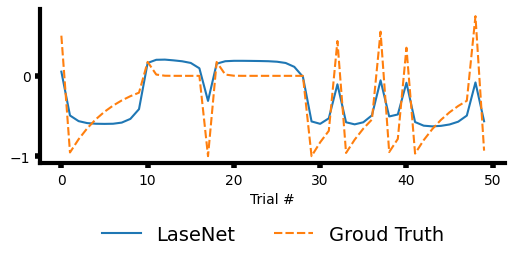

In [22]:
num_agents = test_data.agentid.nunique()
num_trials = test_data.trials.nunique()
lasenet_pred = predicted.reshape((num_agents, num_trials))
true_label = test_data[target_parameter_name].to_numpy().reshape((num_agents, num_trials))

nrows, n_cols = 1, 1
fig, ax = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(n_cols*6, nrows*2), sharey=True, sharex=True)

max_trial = 50
agent_idx = 5
result = {
    'LaseNet': lasenet_pred[agent_idx][:max_trial],
    'Groud Truth': true_label[agent_idx][:max_trial],
}

plt.rcParams.update({'font.size': 14})
plot_ = sns.lineplot(result, ax=ax, legend=True)
sns.move_legend(
  ax, "lower center",
  bbox_to_anchor=(0.5, -0.64), ncol=len(result), title=None, frameon=False,
)
ax.set_xlabel('Trial #')

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=4)
sns.despine()

## Hyperparameter Tuning

In [ ]:
# For grid search
!pip install --upgrade keras-hypetune
!pip install -q -U keras-tuner

In [ ]:
def get_model(parms):
    lasenet = create_model(
        parms["feature_dim"],
        parms["discrete_output_dim"],
        parms["continuous_output_dim"],
        parms["units"],
        parms["dropout"],
        parms["dropout1"],
        parms["dropout2"],
    )
    optimizer = Adam(learning_rate=parms["learning_rate"])
    lasenet.compile(
        loss={
            "continuous_latent": "mse",
        },
        loss_weights={"continuous_latent": 1},
        optimizer=optimizer,
    )
    return lasenet

In [ ]:
from kerashypetune import KerasBayesianSearch
from hyperopt import hp, Trials

param_grid = {
  'feature_dim': X_train.shape[-1],
  'continuous_output_dim': 1,
  'discrete_output_dim': 0,
  'units': hp.choice('units', [96, 128, 256]),
  'learning_rate': 3e-4,
  'dropout': hp.uniform('dropout', .05, .25),
  'dropout1': hp.uniform('dropout1', .01, .1),
  'dropout2': hp.uniform('dropout2', .01, .05),
  'epochs': 25,
  'batch_size': 128,
}

n_iter = 1 # We set it to 10 in our work
kbs = KerasBayesianSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False, n_iter=n_iter, sampling_seed=33)
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]
kbs.search(
    X_train,
    y_train,
    trials=Trials(),
    validation_split=0.1,
    callbacks=callbacks)

print(kbs.best_params)
print(kbs.scores)